# COMP551 Mini Project 1

## Groupe 58 : Saad Benslimane, Dun Yuan, Yuhongze Zhou

# Importing Librairies and functions we need for this assignment

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load
import datawig

# Functions

- The function "information_data" return informations about variables from our data. Informations like : a list of variable's name, a list of variable's class, a list of numerical variable and a list of categorical variable.
- The function "normaliza_data" return normalized values using min-max scaling method. The values returned will be between 0 and 1.
- The function "split_data" return a list of index for N splits, we will use this list for the K-Fold cross validation method to split our data.
- The function "Decision_Tree_classifier" apply the decision classifier model. This function takes some arguments like : train data, validation data, and depth.
- The function "KNN_classifier" apply the K-Nearest Neighbors classifier model. This function takes some arguments like : train data, validation data, and k.
- The function "missins_values" check the number of missing values in every column and return a list of index rows to delete from the data, list of column's name with missing values, a list with index missing values for every columns.


In [2]:
def informations_data(file_path):
    variable_name = []
    variable_class = []
    numerical_var = []
    categorical_var = []
    with open(file_path,'r') as f:
        for line in f.readlines():
            if (line[0] != '|') and (line.strip() != ''):
                if (line.strip() != ">50K, <=50K."):
                    index = line.find(':')
                    name_ = line[:index]
                    class_ = (line[index+1:].strip()[:-1]).split(', ')
                    variable_name.append(name_)
                    variable_class.append(class_)
                    if class_[0] == 'continuous':
                        numerical_var.append(name_)
                    else:
                        categorical_var.append(name_)
    return variable_name, variable_class, numerical_var, categorical_var

In [3]:
def normalize_data(X):
    Max = np.max(X)
    Min = np.min(X)
    return (X - Min) / (Max - Min)

In [4]:
def split_data(data, num_split):
    length = data.shape[0] // num_split
    splits = []
    for i in range(num_split-1):
        splits.append(np.arange(i*length, (i+1)*length))
    splits.append(np.arange((num_split-1)*length, data.shape[0]))
    return splits

In [5]:
def KNN_classifier(input_train, output_train, input_val, output_val, k):
    
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    model = model.fit(input_train, output_train)
    output_pred = model.predict(input_val)
    
    return output_pred, output_val, model

In [6]:
def Decision_Tree_classifier(input_train, output_train, input_val, output_val, depth):
    
    model = DecisionTreeClassifier(criterion = "entropy", max_depth = depth)
    model = model.fit(input_train, output_train)
    output_pred = model.predict(input_val)
    
    return output_pred, output_val, model

In [7]:
def missins_values(df, variable_name):
    missing_indices = set()
    missing_columns = []
    missing_indices_dict = {}

    for name in variable_name:
        missing_index = set(df[df[name].isnull()].index.values)
        missing_indices = missing_indices.union(missing_index)
        n_miss = df[name].isnull().sum()
        perc = n_miss / df.shape[0] * 100
        if n_miss > 0 :
            missing_columns.append(name)
            missing_indices_dict[name] = missing_index
        print('%s : %d (%.1f%%)' % (name, n_miss, perc))
        
    return missing_indices, missing_columns, missing_indices_dict

In [8]:
def evaluate_knn(link, average) :
    for idx, (cv_train, cv_validation) in enumerate(cross_validation(output_train, num_split=num_split)):
        input_train_cv = input_train[cv_train]
        output_train_cv = output_train[cv_train]
        input_validation_cv = input_train[cv_validation]
        output_validation_cv = output_train[cv_validation]

        for k in neighbors:
            if os.path.exists(link+"{}-NN_{}-fold_cv-{}.joblib".format(k, num_split, idx+1)):
                continue
            output_pred, output_real, KNN = KNN_classifier(input_train_cv, output_train_cv, input_validation_cv, 
                                                           output_validation_cv, k)

            #acc_train = accuracy_score(output_train_cv, KNN.predict(input_train_cv))
            acc_val = accuracy_score(output_real, output_pred)
            f1_val = f1_score(output_real, output_pred, average=average)
            #knn_acc_train[k].append(acc_train)
            knn_acc_val[k].append(acc_val)
            knn_f1_score_val[k].append(f1_val)
            #print("{}-NN for {}-fold, cv_{} : acc: {}, F1-score: {}".format(k, num_split, idx+1, round(acc_val, 7), round(f1_val, 7)))
            dump(KNN,link+"{}-NN_{}-fold_cv-{}.joblib".format(k, num_split, idx+1))

    for k in neighbors:
        print("For k = {}".format(k))
        #print("{}-Fold Cross-validation Mean Accuracy for train data : {}".format(num_split, round(np.mean(np.array(knn_acc_train[k])), 7)))
        #knn_acc_train_mean[k].append(round(np.mean(np.array(knn_acc_train[k])), 7))
        print("{}-Fold Cross-validation Mean Accuracy for validation data : {}".format(num_split, round(np.mean(np.array(knn_acc_val[k])), 7)))
        knn_acc_val_mean[k].append(round(np.mean(np.array(knn_acc_val[k])), 7))
        print("{}-Fold Cross-validation Best KNN Model idx: {}".format(num_split, np.argmax(np.array(knn_acc_val[k]))))
        idx = np.argmax(np.array(knn_acc_val[k]))
        model = load(link+"{}-NN_{}-fold_cv-{}.joblib".format(k, num_split, idx+1))
        test_pred = model.predict(input_test)
        print("{}-Fold Cross-validation Test Accuracy: {}".format(num_split, round(accuracy_score(output_test, test_pred), 7)))
        knn_acc_test[k].append(round(accuracy_score(output_test, test_pred), 7))
        print("{}-Fold Cross-validation Test F1-score: {}".format(num_split, round(f1_score(output_test, test_pred, average=average), 7)))
        knn_f1_score_test[k].append(round(f1_score(output_test, test_pred, average=average), 7))
        print("\n")

In [9]:
def evaluate_decision(link, average) :
    for idx, (cv_train, cv_validation) in enumerate(cross_validation(output_train, num_split=num_split)):
        input_train_cv = input_train[cv_train]
        output_train_cv = output_train[cv_train]
        input_validation_cv = input_train[cv_validation]
        output_validation_cv = output_train[cv_validation]

        for depth in depths:
            if os.path.exists(link+"{}-Decision-Tree_{}-fold_cv-{}.joblib".format(depth, num_split, idx+1)):
                continue
            output_pred, output_real, DTC = Decision_Tree_classifier(input_train_cv, output_train_cv, input_validation_cv, 
                                                           output_validation_cv, depth)

            acc_train = accuracy_score(output_train_cv, DTC.predict(input_train_cv))
            acc_val = accuracy_score(output_real, output_pred)
            f1_val = f1_score(output_real, output_pred, average=average)
            dtc_acc_train[depth-5].append(acc_train)
            dtc_acc_val[depth-5].append(acc_val)
            dtc_f1_score_val[depth-5].append(f1_val)
            #print("{}-Decision Tree for {}-fold, cv-{} : acc: {}, F1-score: {}".format(depth, num_split, idx+1, round(acc_val, 7), round(f1_val, 7)))
            dump(DTC,link+"{}-Decision-Tree_{}-fold_cv-{}.joblib".format(depth, num_split, idx+1))

    for depth in depths:
        print("For depth = {}".format(depth))
        print("{}-Fold Cross-validation Mean Accuracy for train data : {}".format(num_split, round(np.mean(np.array(dtc_acc_train[depth-5])), 7)))
        dtc_acc_train_mean[depth].append(round(np.mean(np.array(dtc_acc_train[depth-5])), 7))
        print("{}-Fold Cross-validation Mean Accuracy for validation data : {}".format(num_split, round(np.mean(np.array(dtc_acc_val[depth-5])), 7)))
        dtc_acc_val_mean[depth].append(round(np.mean(np.array(dtc_acc_val[depth-5])), 7))
        print("{}-Fold Cross-validation Best KNN Model idx: {}".format(num_split, np.argmax(np.array(dtc_acc_val[depth-5]))))
        idx = np.argmax(np.array(dtc_acc_val[depth-5]))
        model = load(link+"{}-Decision-Tree_{}-fold_cv-{}.joblib".format(depth, num_split, idx+1))
        test_pred = model.predict(input_test)
        print("{}-Fold Cross-validation Test Accuracy: {}".format(num_split, round(accuracy_score(output_test, test_pred), 7)))
        dtc_acc_test[depth].append(round(accuracy_score(output_test, test_pred), 7))        
        print("{}-Fold Cross-validation Test F1-score: {}".format(num_split, round(f1_score(output_test, test_pred, average=average), 7)))
        dtc_f1_score_test[depth].append(round(f1_score(output_test, test_pred, average=average), 7))
        print("\n")


# Load the first dataset

The data will use here represent the income of some people based on somes variables like : age, work class, degree, job title, hours work per week, country, relationship, race, sex...
After loading the data, we'll show the first rows, informations and statistics about our data.

Source : https://archive.ics.uci.edu/ml/datasets/Adult

In [10]:
# Show all columns
pd.set_option('display.max_columns', None)
# Get informations from data
variable_name, variable_class, numerical_var, categorical_var = informations_data(os.path.join("Data_1/adult.names"))
# Load train data
df_train = pd.read_csv("Data_1/adult.data", sep=", ", header=None, names=variable_name+["Income"], na_values="?", engine='python', encoding="utf-8-sig")
# Load test data
df_test = pd.read_csv("Data_1/adult.test", sep=", ", header=None, names=variable_name+["Income"], skiprows=1, na_values="?", engine='python', encoding="utf-8-sig")

In [11]:
# Show the first 5 rows of our data
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# Show columns names of our data
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income'],
      dtype='object')

In [13]:
print("The training data is composed of %d rows and %d columns." %df_train.shape)
print("The testing data is composed of %d rows and %d columns." %df_test.shape)

The training data is composed of 32561 rows and 15 columns.
The testing data is composed of 16281 rows and 15 columns.


In [14]:
df_test.loc[df_test.Income == "<=50K.", "Income"] = "<=50K"
df_test.loc[df_test.Income == ">50K.", "Income"] = ">50K"

In [15]:
# Statistics about train data
less_50k = sum(df_train.Income == "<=50K")
exceed_50k = sum(df_train.Income == ">50K")
exceed_percentage = (exceed_50k / df_train.shape[0]) * 100
print("People who earn less than 50k in train data : %d " %less_50k)
print("People who earn more than 50k in train data : %d " %exceed_50k)
print("Percentage of people earning more than 50k : %d" %exceed_percentage, "%")

People who earn less than 50k in train data : 24720 
People who earn more than 50k in train data : 7841 
Percentage of people earning more than 50k : 24 %


In [16]:
# Statistics about test data
less_50k = sum(df_test.Income == "<=50K")
exceed_50k = sum(df_test.Income == ">50K")
exceed_percentage = (exceed_50k / df_test.shape[0]) * 100
print("People who earn less than 50k in test data : %d " %less_50k)
print("People who earn more than 50k in test data : %d " %exceed_50k)
print("Percentage of people earning more than 50k : %d" %exceed_percentage, "%")

People who earn less than 50k in test data : 12435 
People who earn more than 50k in test data : 3846 
Percentage of people earning more than 50k : 23 %


In [17]:
# Data description
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [18]:
# Data types
df_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
Income            object
dtype: object

# Drop columns with missing values

Before run our models we should make sur to remove missing values. We can't remove the columns because it's a lose of informations, so we're going just to remove the rows with missings values.

In [19]:
train_missing_indices = set()
train_missing_columns = []
train_missing_indices_dict = {}

test_missing_indices = set()
test_missing_columns = []
test_missing_indices_dict = {}

In [20]:
print("\033[1m","Checking train data","\033[0m")
train_missing_indices, train_missing_columns, train_missing_indices_dict = missins_values(df_train, variable_name)

 Checking train data 
age : 0 (0.0%)
workclass : 1836 (5.6%)
fnlwgt : 0 (0.0%)
education : 0 (0.0%)
education-num : 0 (0.0%)
marital-status : 0 (0.0%)
occupation : 1843 (5.7%)
relationship : 0 (0.0%)
race : 0 (0.0%)
sex : 0 (0.0%)
capital-gain : 0 (0.0%)
capital-loss : 0 (0.0%)
hours-per-week : 0 (0.0%)
native-country : 583 (1.8%)


In [21]:
print("\033[1m","Checking test data","\033[0m")
test_missing_indices, test_missing_columns, test_missing_indices_dict = missins_values(df_test, variable_name)

 Checking test data 
age : 0 (0.0%)
workclass : 963 (5.9%)
fnlwgt : 0 (0.0%)
education : 0 (0.0%)
education-num : 0 (0.0%)
marital-status : 0 (0.0%)
occupation : 966 (5.9%)
relationship : 0 (0.0%)
race : 0 (0.0%)
sex : 0 (0.0%)
capital-gain : 0 (0.0%)
capital-loss : 0 (0.0%)
hours-per-week : 0 (0.0%)
native-country : 274 (1.7%)


In [22]:
train_missing_indices = list(train_missing_indices)
test_missing_indices = list(test_missing_indices)

print("length of dropped instances in train data : {}".format(len(train_missing_indices)))
print("length of dropped instances in test data : {}".format(len(test_missing_indices)))

length of dropped instances in train data : 2399
length of dropped instances in test data : 1221


In [23]:
# Drop rows with missing values from train data
df_train.drop(train_missing_indices, inplace=True)
# Drow rows with missing values from test data
df_test.drop(test_missing_indices, inplace=True)

In [24]:
# Define inout and output data
df_train = df_train.sample(frac=1,random_state=0).reset_index(drop=True)
output_train = df_train["Income"]
input_train = df_train.drop(["Income"],axis=1)
output_test = df_test["Income"]
input_test = df_test.drop(["Income"],axis=1)

# Apply One Hot encoder

One hot Encoder consists in encoding a categorical variable with n categories to n binary variables. In other words the i-th binary variable representing the i-th category.
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [25]:
# Convert discrete variables into multiple variables using one-hot encoding
from sklearn.compose import make_column_transformer
sub_categorical_var = [c_v for c_v in categorical_var]
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), sub_categorical_var), 
                                       remainder="passthrough")
preprocessor.fit(input_train)
input_train = preprocessor.transform(input_train)
input_test = preprocessor.transform(input_test)


In [26]:
# Convert target label to binary
output_train = output_train.values
output_train[output_train=='<=50K'] = 0
output_train[output_train=='>50K'] = 1
output_train = output_train.astype(np.int)

output_test = output_test.values
output_test[output_test=='<=50K'] = 0
output_test[output_test=='>50K'] = 1
output_test = output_test.astype(np.int)

<ipython-input-26-4b918d55e3f3>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_train = output_train.astype(np.int)
<ipython-input-26-4b918d55e3f3>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

# 5-Fold cross validation

In [27]:
# 5-fold cross-validation
num_split = 5

def cross_validation(output_train, num_split=5):
    index_split = split_data(output_train, num_split = num_split)
    for i in range(num_split):
        cv_validation = index_split[i]
        cv_train = np.empty(shape=(0,),dtype=int)

        if i>0:
            cv_train = np.concatenate([index_split[j] for j in range(i)],axis=0)
        if i<num_split-1:
            cv_train = np.concatenate([cv_train, np.concatenate([index_split[j] for j in range(i+1,num_split)],axis=0)],axis=0)
            
        yield cv_train, cv_validation


# K-Nearest Neighbours

After we convert categorical variables to numerical variables using One Hot Encoder. First we're going to apply KNN on the first data for multiple values of K, then we'll save our models to classificate our test data using the best model for each K value.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

For each value of K, we'll see the mean value of the accuracy and the F1-score of the KNN model. After that we'll use the best model for every K value to classificate the test data"

In [28]:
#knn_acc_train = defaultdict(list)
knn_acc_val = defaultdict(list)
knn_f1_score_val = defaultdict(list)
#knn_acc_train_mean = defaultdict(list)
knn_acc_val_mean = defaultdict(list)
knn_acc_test = defaultdict(list)
knn_f1_score_test = defaultdict(list)
# List of k values to test
neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# Adress where to save the models
link = "KNN_1/OHE/"
# Run the evaluation
evaluate_knn(link, average='binary')

For k = 1
5-Fold Cross-validation Mean Accuracy for validation data : 0.720609
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7191899
5-Fold Cross-validation Test F1-score: 0.4412736


For k = 2
5-Fold Cross-validation Mean Accuracy for validation data : 0.7209074
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7199867
5-Fold Cross-validation Test F1-score: 0.4412349


For k = 3
5-Fold Cross-validation Mean Accuracy for validation data : 0.7448452
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7450199
5-Fold Cross-validation Test F1-score: 0.4394161


For k = 4
5-Fold Cross-validation Mean Accuracy for validation data : 0.7502825
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7496016
5-Fold Cross-validation Test F1-score: 0.4370802


For k = 5
5-Fold Cross-validation Mean Accuracy for validation data : 0.7600631
5-Fold Cross-vali

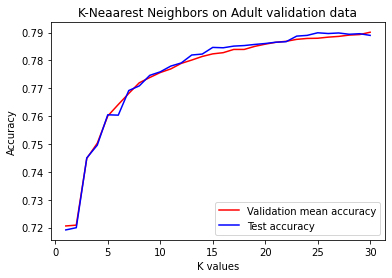

In [29]:
# Vizualise result for validation data
plt.plot(knn_acc_val_mean.keys(), knn_acc_val_mean.values(), "red", label="Validation mean accuracy")
plt.plot(knn_acc_test.keys(), knn_acc_test.values(), "blue", label="Test accuracy")
plt.xlabel("K values")
plt.ylabel("Accuracy")
plt.title("K-Neaarest Neighbors on Adult validation data")
plt.legend()

# Decision Tree Classifier

Now we're going to apply decision tree classifier using multiple value of depth : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

For each value of depth, we'll see the mean value of the accuracy and the F1-score of the decision model. After that we'll use the best model for every depth value to classificate the test data.

In [30]:
dtc_acc_train = defaultdict(list)
dtc_acc_val = defaultdict(list)
dtc_f1_score_val = defaultdict(list)
dtc_acc_train_mean = defaultdict(list)
dtc_acc_val_mean = defaultdict(list)
dtc_acc_test = defaultdict(list)
dtc_f1_score_test = defaultdict(list)
# List of depth values to test
depths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# Adress where to save the models
link = "Decision_tree_1/OHE/"
# Run the evaluation
evaluate_decision(link, average='binary')

For depth = 5
5-Fold Cross-validation Mean Accuracy for train data : 0.8421275
5-Fold Cross-validation Mean Accuracy for validation data : 0.8403621
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.8390438
5-Fold Cross-validation Test F1-score: 0.6061098


For depth = 6
5-Fold Cross-validation Mean Accuracy for train data : 0.8493469
5-Fold Cross-validation Mean Accuracy for validation data : 0.846794
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.8444223
5-Fold Cross-validation Test F1-score: 0.6264945


For depth = 7
5-Fold Cross-validation Mean Accuracy for train data : 0.8524965
5-Fold Cross-validation Mean Accuracy for validation data : 0.8490816
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.8460159
5-Fold Cross-validation Test F1-score: 0.6292566


For depth = 8
5-Fold Cross-validation Mean Accuracy for train data : 0.8566574
5-Fold Cross-validation Mean Accuracy

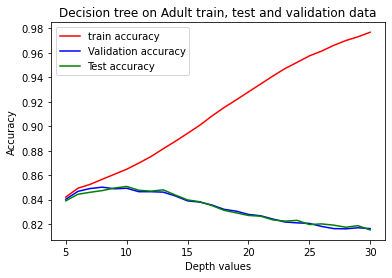

In [31]:
# Vizualise result for validation data
plt.plot(dtc_acc_train_mean.keys(), dtc_acc_train_mean.values(), "red", label="train accuracy")
plt.plot(dtc_acc_val_mean.keys(), dtc_acc_val_mean.values(), "blue", label="Validation accuracy")
plt.plot(dtc_acc_test.keys(), dtc_acc_test.values(), "green", label="Test accuracy")
plt.xlabel("Depth values")
plt.ylabel("Accuracy")
plt.title("Decision tree on Adult train, test and validation data")
plt.legend()

# The impact of the size of the database on the error

In this section, we're going to sample growing subsets of data and run our models so we can study the impact of size data. Every step we'll remove 10% of the data"

In [32]:
KNN_val = []
KNN_test = []
DT_train = []
DT_val = []
DT_test = []
original_input_train = input_train.copy()
original_output_train=output_train.copy()
for i in range(10,0,-1):

    size = original_output_train.shape[0] * i / 10
    input_train = original_input_train[0:int(size)]
    output_train = original_output_train[0:int(size)]

    # 5-fold cross-validation
    num_split = 5

    # Apply KNN model
    #knn_acc_train = defaultdict(list)
    knn_acc_val = defaultdict(list)
    knn_f1_score_val = defaultdict(list)
    #knn_acc_train_mean = defaultdict(list)
    knn_acc_val_mean = defaultdict(list)
    knn_acc_test = defaultdict(list)
    knn_f1_score_test = defaultdict(list)
    # List of k values to test
    neighbors = [20]
    # Adress where to save the models
    link = "KNN_1/OHE_size{}/".format(i)
    # Run the evaluation
    evaluate_knn(link, average='binary')


    # Apply Decision tree model
    dtc_acc_train = defaultdict(list)
    dtc_acc_val = defaultdict(list)
    dtc_f1_score_val = defaultdict(list)
    dtc_acc_train_mean = defaultdict(list)
    dtc_acc_val_mean = defaultdict(list)
    dtc_acc_test = defaultdict(list)
    dtc_f1_score_test = defaultdict(list)
    # List of depth values to test
    depths = [10]
    # Adress where to save the models
    link = "Decision_tree_1/OHE_size{}/".format(i)
    # Run the evaluation
    evaluate_decision(link, average='binary')


    KNN_val.append(knn_acc_val_mean[20][0])
    KNN_test.append(knn_acc_test[20][0])
    DT_train.append(dtc_acc_train_mean[10][0])
    DT_val.append(dtc_acc_val_mean[10][0])
    DT_test.append(dtc_acc_test[10][0])

output_train=original_output_train

For k = 20
5-Fold Cross-validation Mean Accuracy for validation data : 0.7858237
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7860558
5-Fold Cross-validation Test F1-score: 0.3950432


For depth = 10
5-Fold Cross-validation Mean Accuracy for train data : 0.8648796
5-Fold Cross-validation Mean Accuracy for validation data : 0.8493138
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.8511288
5-Fold Cross-validation Test F1-score: 0.6529412


For k = 20
5-Fold Cross-validation Mean Accuracy for validation data : 0.7876957
5-Fold Cross-validation Best KNN Model idx: 4
5-Fold Cross-validation Test Accuracy: 0.788579
5-Fold Cross-validation Test F1-score: 0.3983371


For depth = 10
5-Fold Cross-validation Mean Accuracy for train data : 0.8655369
5-Fold Cross-validation Mean Accuracy for validation data : 0.8476699
5-Fold Cross-validation Best KNN Model idx: 2
5-Fold Cross-validation Test Accuracy: 0.8521248
5-Fold

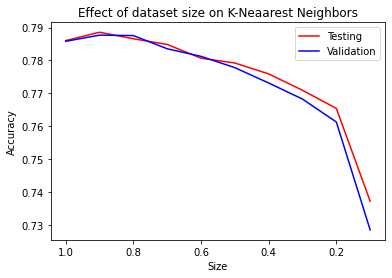

In [33]:
x = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]


ax = plt.figure().gca()
ax.invert_xaxis()
# Vizualise result for validation data
plt.plot(x, KNN_test, "red", label="Testing")
plt.plot(x, KNN_val, "blue", label="Validation")
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.title("Effect of dataset size on K-Neaarest Neighbors")
plt.legend()

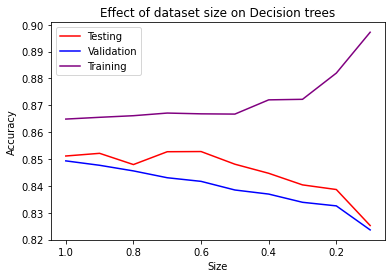

In [34]:
x = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]


ax = plt.figure().gca()
ax.invert_xaxis()
# Vizualise result for validation data
plt.plot(x, DT_test, "red", label="Testing")
plt.plot(x, DT_val, "blue", label="Validation")
plt.plot(x, DT_train, "purple", label="Training")
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.title("Effect of dataset size on Decision trees")
plt.legend()

# Optional : Impute Missing values

To handle with missing values, we'll use simple imputer from datawig to impute values in our data.
source : https://datawig.readthedocs.io/en/latest/source/API.html#module-datawig.simple_imputer

In [35]:
# Show all columns
pd.set_option('display.max_columns', None)
# Get informations from data
variable_name, variable_class, numerical_var, categorical_var = informations_data(os.path.join("Data_1/adult.names"))
# Load train data
df_train = pd.read_csv("Data_1/adult.data", sep=", ", header=None, names=variable_name+["Income"], na_values="?", engine='python', encoding="utf-8-sig")
# Load test data
df_test = pd.read_csv("Data_1/adult.test", sep=", ", header=None, names=variable_name+["Income"], skiprows=1, na_values="?", engine='python', encoding="utf-8-sig")

train_missing_indices = set()
train_missing_columns = []
train_missing_indices_dict = {}

test_missing_indices = set()
test_missing_columns = []
test_missing_indices_dict = {}

print("\033[1m","Checking train data","\033[0m")
train_missing_indices, train_missing_columns, train_missing_indices_dict = missins_values(df_train, variable_name)
print("\033[1m","Checking test data","\033[0m")
test_missing_indices, test_missing_columns, test_missing_indices_dict = missins_values(df_test, variable_name)

train_missing_indices = list(train_missing_indices)
test_missing_indices = list(test_missing_indices)

print("\033[1m","length of dropped instances in train data : {}","\033[0m".format(len(train_missing_indices)))
print("\033[1m","length of dropped instances in test data : {}","\033[0m".format(len(test_missing_indices)))

non_missing_columns = list(set(variable_name).difference(set(train_missing_columns)))
train_imputed = []
test_imputed = []

for i, missing_column in enumerate(train_missing_columns):
    
    if os.path.exists('imputer_{}_model'.format(missing_column)):
        imputer = datawig.SimpleImputer.load('imputer_{}_model'.format(missing_column))
    else:
        imputer = datawig.SimpleImputer(input_columns = list(set(variable_name).difference(set([missing_column]))), 
                                        output_column = missing_column, 
                                        output_path = 'imputer_{}_model'.format(missing_column))
        imputer.fit(train_df = df_train.loc[list(df_train[df_train[missing_column].notnull()].index.values), 
                                              variable_name])
        select_data = df_train.loc[list(train_missing_indices_dict[missing_column]), variable_name]
    
    imputed = imputer.predict(df_train.loc[list(train_missing_indices_dict[missing_column]), variable_name])
    train_imputed.append(imputed[missing_column+"_imputed"])

    imputed = imputer.predict(df_test.loc[list(test_missing_indices_dict[missing_column]), variable_name])
    test_imputed.append(imputed[missing_column+"_imputed"])

for i, missing_column in enumerate(train_missing_columns):
    df_train.loc[list(train_missing_indices_dict[missing_column]),missing_column] = train_imputed[i]
    df_test.loc[list(test_missing_indices_dict[missing_column]),missing_column] = test_imputed[i]


 Checking train data 
age : 0 (0.0%)
workclass : 1836 (5.6%)
fnlwgt : 0 (0.0%)
education : 0 (0.0%)
education-num : 0 (0.0%)
marital-status : 0 (0.0%)
occupation : 1843 (5.7%)
relationship : 0 (0.0%)
race : 0 (0.0%)
sex : 0 (0.0%)
capital-gain : 0 (0.0%)
capital-loss : 0 (0.0%)
hours-per-week : 0 (0.0%)
native-country : 583 (1.8%)
 Checking test data 
age : 0 (0.0%)
workclass : 963 (5.9%)
fnlwgt : 0 (0.0%)
education : 0 (0.0%)
education-num : 0 (0.0%)
marital-status : 0 (0.0%)
occupation : 966 (5.9%)
relationship : 0 (0.0%)
race : 0 (0.0%)
sex : 0 (0.0%)
capital-gain : 0 (0.0%)
capital-loss : 0 (0.0%)
hours-per-week : 0 (0.0%)
native-country : 274 (1.7%)
 length of dropped instances in train data : {} 
 length of dropped instances in test data : {} 


# Optional : One Hot Encoder + Normalization + PCA

After imputing values in missing observation, we'll apply another time the OneHotEncoder to convert categorical variables to numerical variables. And before reduce data dimension, we should normalize our dataset.

source : https://en.wikipedia.org/wiki/Normalization_(statistics)
https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [36]:
df_train = df_train.sample(frac=1,random_state=0).reset_index(drop=True)
output_train = df_train["Income"]
input_train = df_train.drop(["Income"],axis=1)
output_test = df_test["Income"]
input_test = df_test.drop(["Income"],axis=1)

In [37]:
# Convert discrete variables into multiple variables using one-hot encoding
for name_, class_ in zip(variable_name, variable_class):  
    # Convert discrete variables using one-hot encoding
    if (class_[0] == 'continuous') :
        input_train[name_] = normalize_data(input_train[name_].values)
        input_test[name_] = normalize_data(input_test[name_].values)

In [38]:
# Convert discrete variables into multiple variables using one-hot encoding
from sklearn.compose import make_column_transformer
sub_categorical_var = [c_v for c_v in categorical_var]
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), sub_categorical_var), 
                                       remainder="passthrough")
preprocessor.fit(input_train)
input_train = preprocessor.transform(input_train)
input_test = preprocessor.transform(input_test)


In [39]:
# Convert target label to binary
df_test.loc[df_test.Income == "<=50K.", "Income"] = "<=50K"
df_test.loc[df_test.Income == ">50K.", "Income"] = ">50K"
output_train = output_train.values
output_train[output_train=='<=50K'] = 0
output_train[output_train=='>50K'] = 1
output_train = output_train.astype(np.int)

output_test = output_test.values
output_test[output_test=='<=50K'] = 0
output_test[output_test=='>50K'] = 1
output_test = output_test.astype(np.int)

<ipython-input-39-a1f0cfaaf133>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_train = output_train.astype(np.int)
<ipython-input-39-a1f0cfaaf133>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_train = pca.fit_transform(input_train)
input_test = pca.fit_transform(input_test)

# K-Nearest Neighbors Classifier

In [41]:
#knn_acc_train = defaultdict(list)
knn_acc_val = defaultdict(list)
knn_f1_score_val = defaultdict(list)
#knn_acc_train_mean = defaultdict(list)
knn_acc_val_mean = defaultdict(list)
knn_acc_test = defaultdict(list)
knn_f1_score_test = defaultdict(list)
# List of k values to test
neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# Adress where to save the models
link = "KNN_1/OHE_Optional/"
# Run the evaluation
evaluate_knn(link, average='binary')

For k = 1
5-Fold Cross-validation Mean Accuracy for validation data : 0.7664691
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.7491555
5-Fold Cross-validation Test F1-score: 0.4490016


For k = 2
5-Fold Cross-validation Mean Accuracy for validation data : 0.7664691
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.7491555
5-Fold Cross-validation Test F1-score: 0.4490016


For k = 3
5-Fold Cross-validation Mean Accuracy for validation data : 0.7850804
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.77139
5-Fold Cross-validation Test F1-score: 0.4591688


For k = 4
5-Fold Cross-validation Mean Accuracy for validation data : 0.7899327
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.7728641
5-Fold Cross-validation Test F1-score: 0.4579302


For k = 5
5-Fold Cross-validation Mean Accuracy for validation data : 0.7938946
5-Fold Cross-valid

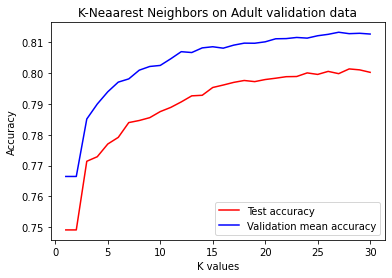

In [42]:
# Vizualise result for validation data
plt.plot(knn_acc_test.keys(), knn_acc_test.values(), "red", label="Test accuracy")
plt.plot(knn_acc_val_mean.keys(), knn_acc_val_mean.values(), "blue", label="Validation mean accuracy")
plt.xlabel("K values")
plt.ylabel("Accuracy")
plt.title("K-Neaarest Neighbors on Adult validation data")
plt.legend()

# Decision Tree Classifier

In [43]:
dtc_acc_train = defaultdict(list)
dtc_acc_val = defaultdict(list)
dtc_f1_score_val = defaultdict(list)
dtc_acc_train_mean = defaultdict(list)
dtc_acc_val_mean = defaultdict(list)
dtc_acc_test = defaultdict(list)
dtc_f1_score_test = defaultdict(list)
# List of depth values to test
depths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# Adress where to save the models
link = "Decision_tree_1/OHE_Optional/"
# Run the evaluation
evaluate_decision(link, average='binary')

For depth = 5
5-Fold Cross-validation Mean Accuracy for train data : 0.8145634
5-Fold Cross-validation Mean Accuracy for validation data : 0.8119529
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.814262
5-Fold Cross-validation Test F1-score: 0.5501339


For depth = 6
5-Fold Cross-validation Mean Accuracy for train data : 0.8176499
5-Fold Cross-validation Mean Accuracy for validation data : 0.8122907
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.8091026
5-Fold Cross-validation Test F1-score: 0.542268


For depth = 7
5-Fold Cross-validation Mean Accuracy for train data : 0.822917
5-Fold Cross-validation Mean Accuracy for validation data : 0.8147784
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.808427
5-Fold Cross-validation Test F1-score: 0.5408509


For depth = 8
5-Fold Cross-validation Mean Accuracy for train data : 0.8274546
5-Fold Cross-validation Mean Accuracy fo

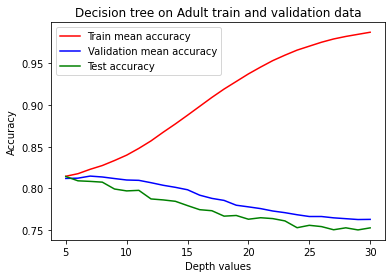

In [44]:
# Vizualise result for validation data
plt.plot(dtc_acc_train_mean.keys(), dtc_acc_train_mean.values(), "red", label="Train mean accuracy")
plt.plot(dtc_acc_val_mean.keys(), dtc_acc_val_mean.values(), "blue", label="Validation mean accuracy")
plt.plot(dtc_acc_test.keys(), dtc_acc_test.values(), "green", label="Test accuracy")
plt.xlabel("Depth values")
plt.ylabel("Accuracy")
plt.title("Decision tree on Adult train and validation data")
plt.legend()


# Load the second data

The Avila data set has been extracted from 800 images of the the "Avila Bible", a giant Latin copy of the whole Bible produced during the XII century between Italy and Spain.  
The palaeographic analysis of the  manuscript has  individuated the presence of 12 copyists. The pages written by each copyist are not equally numerous. 
Each pattern contains 10 features and corresponds to a group of 4 consecutive rows.

The prediction task consists in associating each pattern to one of the 12 copyists (labeled as: A, B, C, D, E, F, G, H, I, W, X, Y).
The data have has been normalized, by using the Z-normalization method, and divided in two data sets: a training set containing 10430 samples, and a test set  containing the 10437 samples.

What's good in this dataset is we don't have missing values and the variables are already normalized.

Source : https://archive.ics.uci.edu/ml/datasets/Avila

In [45]:
names = ["intercolumnar distance", "upper margin", "lower margin", "exploitation", "row number", "modular ratio",
         "interlinear spacing", "weight", "peak number", "modular ratio/ interlinear spacing", "Class"]
df_train = pd.read_csv("Data_2/avila-tr.txt", sep = ",", header=None, names=names)
df_test = pd.read_csv("Data_2/avila-ts.txt", sep = ",", header=None, names=names)

In [46]:
# Show data
df_train.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [47]:
# Columns names
df_train.columns

Index(['intercolumnar distance', 'upper margin', 'lower margin',
       'exploitation', 'row number', 'modular ratio', 'interlinear spacing',
       'weight', 'peak number', 'modular ratio/ interlinear spacing', 'Class'],
      dtype='object')

In [48]:
print("The training data is composed of %d rows and %d columns." %df_train.shape)
print("The testing data is composed of %d rows and %d columns." %df_test.shape)

The training data is composed of 10430 rows and 11 columns.
The testing data is composed of 10437 rows and 11 columns.


In [49]:
# Statistics about train data
Classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "W", "X", "Y"]
for classe in Classes :
    percentage = round((sum(df_train.Class == classe) / df_train.shape[0]) *100, 3)
    print("Class {} : {}, {}% ".format(classe, sum(df_train.Class == classe), percentage))


Class A : 4286, 41.093% 
Class B : 5, 0.048% 
Class C : 103, 0.988% 
Class D : 352, 3.375% 
Class E : 1095, 10.499% 
Class F : 1961, 18.802% 
Class G : 446, 4.276% 
Class H : 519, 4.976% 
Class I : 831, 7.967% 
Class W : 44, 0.422% 
Class X : 522, 5.005% 
Class Y : 266, 2.55% 


In [50]:
# Data description
df_train.describe()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing
count,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000
mean,0.000852,0.033611,-0.000525,-0.002387,0.006370,0.013973,0.005605,0.010323,0.012914,0.000818
std,0.991431,3.920868,1.120202,1.008527,0.992053,1.126245,1.313754,1.003507,1.087665,1.007094
min,-3.498799,-2.426761,-3.210528,-5.440122,-4.922215,-7.450257,-11.935457,-4.247781,-5.486218,-6.719324
25%,-0.128929,-0.259834,0.064919,-0.528002,0.172340,-0.598658,-0.044076,-0.541991,-0.372457,-0.516097
50%,0.043885,-0.055704,0.217845,0.095763,0.261718,-0.058835,0.220177,0.111803,0.064084,-0.034513
75%,0.204355,0.203385,0.352988,0.658210,0.261718,0.564038,0.446679,0.654944,0.500624,0.530855
max,11.819916,386.000000,50.000000,3.987152,1.066121,53.000000,83.000000,13.173081,44.000000,4.671232


In [51]:
# Data types
df_train.dtypes

intercolumnar distance                float64
upper margin                          float64
lower margin                          float64
exploitation                          float64
row number                            float64
modular ratio                         float64
interlinear spacing                   float64
weight                                float64
peak number                           float64
modular ratio/ interlinear spacing    float64
Class                                  object
dtype: object

In [52]:
# Define inout and output data
df_train = df_train.sample(frac=1,random_state=0).reset_index(drop=True)
output_train = df_train["Class"]
input_train = df_train.drop(["Class"],axis=1)
output_test = df_test["Class"]
input_test = df_test.drop(["Class"],axis=1)

In [53]:
# To array
input_train = input_train.values
input_test = input_test.values
output_train = output_train.values
output_test = output_test.values

In [54]:
i = 0
for classe in Classes :
    output_train[output_train==classe] = i
    output_test[output_test==classe] = i
    i+=1

output_train = output_train.astype(np.int)
output_test = output_test.astype(np.int)

<ipython-input-54-b03a95e48d29>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output_train = output_train.astype(np.int)
<ipython-input-54-b03a95e48d29>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

# 5-Fold cross validation

In [55]:
# 5-fold cross-validation
num_split = 5

# K-Nearest Neighbours Classifier

In [56]:
knn_acc_train = defaultdict(list)
knn_acc_val = defaultdict(list)
knn_f1_score_val = defaultdict(list)
knn_acc_train_mean = defaultdict(list)
knn_acc_val_mean = defaultdict(list)
knn_acc_test = defaultdict(list)
knn_f1_score_test = defaultdict(list)
# List of k values to test
neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# Adress where to save the models
link = "KNN_2/OHE/"
# Run the evaluation
evaluate_knn(link, average='weighted')

For k = 1
5-Fold Cross-validation Mean Accuracy for validation data : 0.7418025
5-Fold Cross-validation Best KNN Model idx: 2
5-Fold Cross-validation Test Accuracy: 0.7482035
5-Fold Cross-validation Test F1-score: 0.7487144


For k = 2
5-Fold Cross-validation Mean Accuracy for validation data : 0.7418025
5-Fold Cross-validation Best KNN Model idx: 2
5-Fold Cross-validation Test Accuracy: 0.7482035
5-Fold Cross-validation Test F1-score: 0.7487144


For k = 3
5-Fold Cross-validation Mean Accuracy for validation data : 0.7409396
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7497365
5-Fold Cross-validation Test F1-score: 0.7484299


For k = 4
5-Fold Cross-validation Mean Accuracy for validation data : 0.7439118
5-Fold Cross-validation Best KNN Model idx: 3
5-Fold Cross-validation Test Accuracy: 0.7533774
5-Fold Cross-validation Test F1-score: 0.7515377


For k = 5
5-Fold Cross-validation Mean Accuracy for validation data : 0.7435283
5-Fold Cross-val

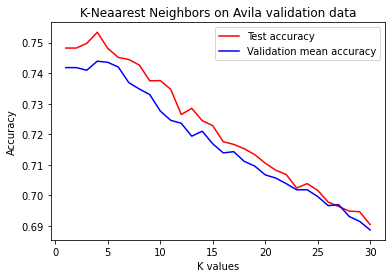

In [57]:
# Vizualise result for validation data
plt.plot(knn_acc_test.keys(), knn_acc_test.values(), "red", label="Test accuracy")
plt.plot(knn_acc_val_mean.keys(), knn_acc_val_mean.values(), "blue", label="Validation mean accuracy")
plt.xlabel("K values")
plt.ylabel("Accuracy")
plt.title("K-Neaarest Neighbors on Avila validation data")
plt.legend()

# Decision Tree Classifier

In [58]:
dtc_acc_train = defaultdict(list)
dtc_acc_val = defaultdict(list)
dtc_f1_score_val = defaultdict(list)
dtc_acc_train_mean = defaultdict(list)
dtc_acc_val_mean = defaultdict(list)
dtc_acc_test = defaultdict(list)
dtc_f1_score_test = defaultdict(list)
# List of depth values to test
depths = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# Adress where to save the models
link = "Decision_tree_2/OHE/"
# Run the evaluation
evaluate_decision(link, average='weighted')

For depth = 5
5-Fold Cross-validation Mean Accuracy for train data : 0.6150048
5-Fold Cross-validation Mean Accuracy for validation data : 0.6126558
5-Fold Cross-validation Best KNN Model idx: 4
5-Fold Cross-validation Test Accuracy: 0.6215388
5-Fold Cross-validation Test F1-score: 0.6105511


For depth = 6
5-Fold Cross-validation Mean Accuracy for train data : 0.6584132
5-Fold Cross-validation Mean Accuracy for validation data : 0.6492809
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.6519115
5-Fold Cross-validation Test F1-score: 0.6391151


For depth = 7
5-Fold Cross-validation Mean Accuracy for train data : 0.7102589
5-Fold Cross-validation Mean Accuracy for validation data : 0.6925216
5-Fold Cross-validation Best KNN Model idx: 4
5-Fold Cross-validation Test Accuracy: 0.6906199
5-Fold Cross-validation Test F1-score: 0.6766019


For depth = 8
5-Fold Cross-validation Mean Accuracy for train data : 0.7626318
5-Fold Cross-validation Mean Accurac

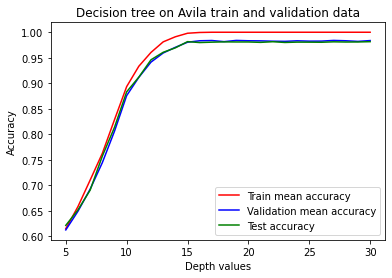

In [59]:
# Vizualise result for validation data
plt.plot(dtc_acc_train_mean.keys(), dtc_acc_train_mean.values(), "red", label="Train mean accuracy")
plt.plot(dtc_acc_val_mean.keys(), dtc_acc_val_mean.values(), "blue", label="Validation mean accuracy")
plt.plot(dtc_acc_test.keys(), dtc_acc_test.values(), "green", label="Test accuracy")
plt.xlabel("Depth values")
plt.ylabel("Accuracy")
plt.title("Decision tree on Avila train and validation data")
plt.legend()


# The impact of the size of the database on the error

We're going to do the same thing we did with the first dataset.

In [60]:
KNN_val = []
KNN_test = []
DT_train = []
DT_val = []
DT_test = []
original_input_train = input_train.copy()
original_output_train=output_train.copy()
for i in range(10,0,-1):

    size = original_output_train.shape[0] * i / 10
    input_train = original_input_train[0:int(size)]
    output_train = original_output_train[0:int(size)]

    # 5-fold cross-validation
    num_split = 5

    # Apply KNN model
    #knn_acc_train = defaultdict(list)
    knn_acc_val = defaultdict(list)
    knn_f1_score_val = defaultdict(list)
    #knn_acc_train_mean = defaultdict(list)
    knn_acc_val_mean = defaultdict(list)
    knn_acc_test = defaultdict(list)
    knn_f1_score_test = defaultdict(list)
    # List of k values to test
    neighbors = [20]
    # Adress where to save the models
    link = "KNN_2/OHE_size{}/".format(i)
    # Run the evaluation
    evaluate_knn(link, average='weighted')


    # Apply Decision tree model
    dtc_acc_train = defaultdict(list)
    dtc_acc_val = defaultdict(list)
    dtc_f1_score_val = defaultdict(list)
    dtc_acc_train_mean = defaultdict(list)
    dtc_acc_val_mean = defaultdict(list)
    dtc_acc_test = defaultdict(list)
    dtc_f1_score_test = defaultdict(list)
    # List of depth values to test
    depths = [10]
    # Adress where to save the models
    link = "Decision_tree_2/OHE_size{}/".format(i)
    # Run the evaluation
    evaluate_decision(link, average='weighted')


    KNN_val.append(knn_acc_val_mean[20][0])
    KNN_test.append(knn_acc_test[20][0])
    DT_train.append(dtc_acc_train_mean[10][0])
    DT_val.append(dtc_acc_val_mean[10][0])
    DT_test.append(dtc_acc_test[10][0])

output_train=original_output_train

For k = 20
5-Fold Cross-validation Mean Accuracy for validation data : 0.7067114
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.710549
5-Fold Cross-validation Test F1-score: 0.6982682


For depth = 10
5-Fold Cross-validation Mean Accuracy for train data : 0.8935043
5-Fold Cross-validation Mean Accuracy for validation data : 0.8763183
5-Fold Cross-validation Best KNN Model idx: 2
5-Fold Cross-validation Test Accuracy: 0.8833956
5-Fold Cross-validation Test F1-score: 0.8827193


For k = 20
5-Fold Cross-validation Mean Accuracy for validation data : 0.7005446
5-Fold Cross-validation Best KNN Model idx: 1
5-Fold Cross-validation Test Accuracy: 0.7017342
5-Fold Cross-validation Test F1-score: 0.6892612


For depth = 10
5-Fold Cross-validation Mean Accuracy for train data : 0.8949071
5-Fold Cross-validation Mean Accuracy for validation data : 0.873975
5-Fold Cross-validation Best KNN Model idx: 2
5-Fold Cross-validation Test Accuracy: 0.8741976
5-Fold 

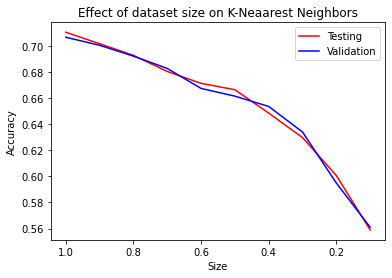

In [61]:
x = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]


ax = plt.figure().gca()
ax.invert_xaxis()
# Vizualise result for validation data
plt.plot(x, KNN_test, "red", label="Testing")
plt.plot(x, KNN_val, "blue", label="Validation")
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.title("Effect of dataset size on K-Neaarest Neighbors")
plt.legend()

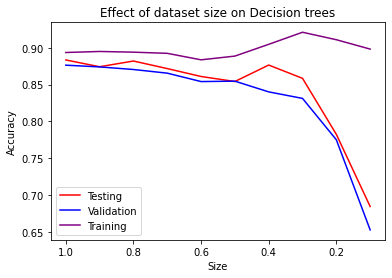

In [62]:
x = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]


ax = plt.figure().gca()
ax.invert_xaxis()
# Vizualise result for validation data
plt.plot(x, DT_test, "red", label="Testing")
plt.plot(x, DT_val, "blue", label="Validation")
plt.plot(x, DT_train, "purple", label="Training")
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.title("Effect of dataset size on Decision trees")
plt.legend()